# Energy: Hourly Energy Consumption Prediction

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system


The hourly power consumption data comes from PJM's website and are in megawatts (MW) by the regions have changed over the years so data may only appear for certain dates per region.

*	Split the last year into a test set- can you build a model to predict energy consumption?
*	Find trends in energy consumption around hours of the day, holidays, or long term trends?
*	Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends.


# Read the data file .csv

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error


df = pd.read_csv('/content/drive/MyDrive/The Data Master/Project Day/Energy/AEP_hourly.csv')

df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


# Information of the data file

Check for null data and other information in the data set





In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [68]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


# Check data type of the data set

In [69]:
df.dtypes

Datetime     object
AEP_MW      float64
dtype: object

# Change the Datetime in data set to Date and Time format

In [70]:
df['Datetime'] = pd.to_datetime(df.Datetime)
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [71]:
df.dtypes

Datetime    datetime64[ns]
AEP_MW             float64
dtype: object

# See overall data set graph

<Axes: xlabel='Datetime'>

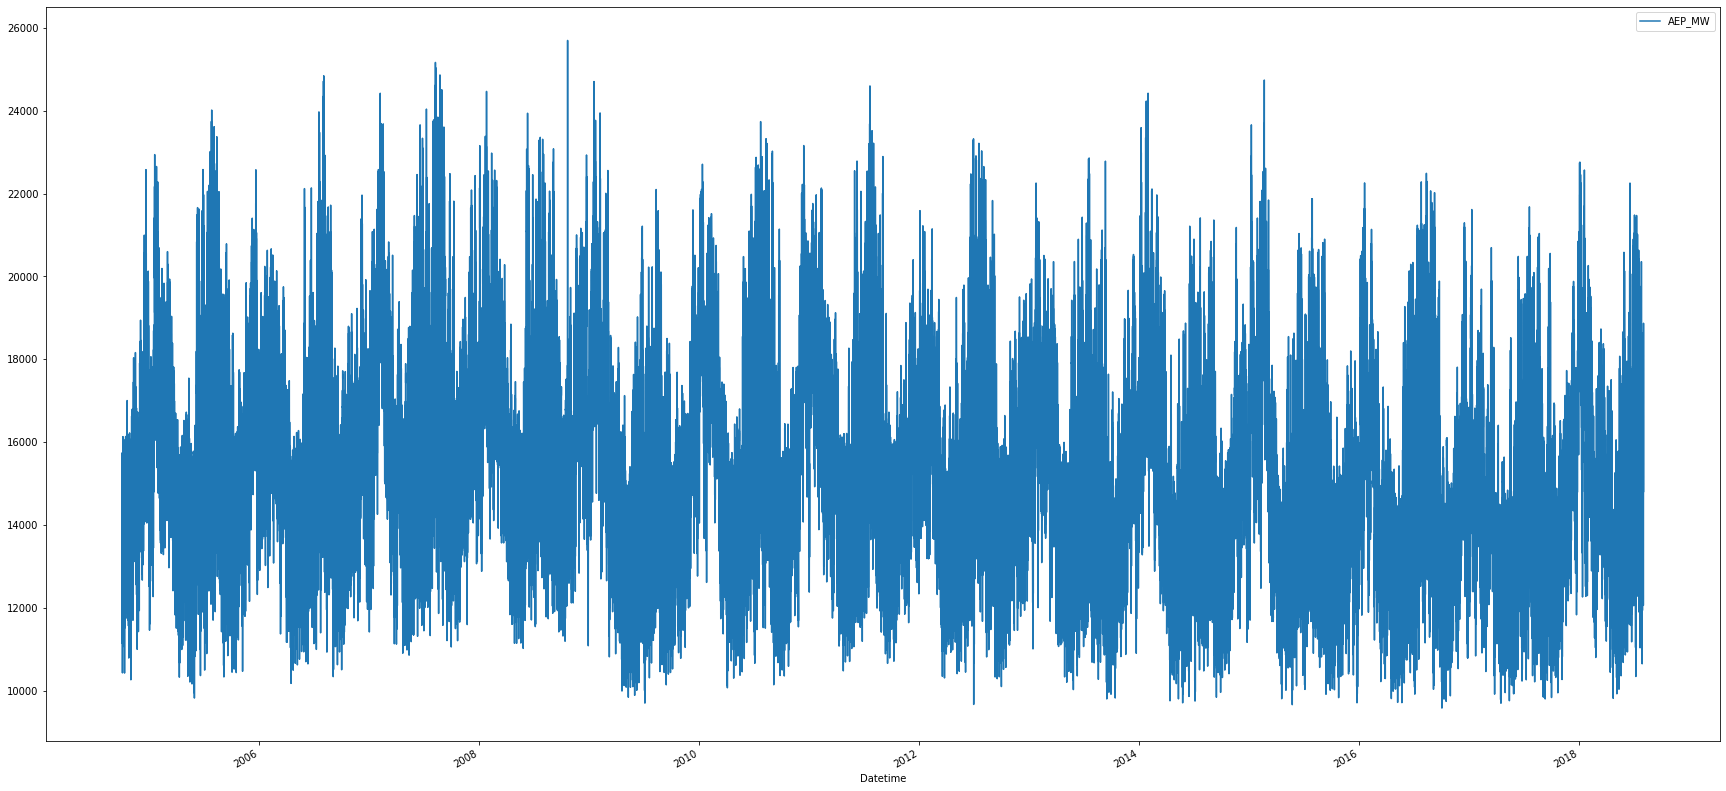

In [72]:
df.plot(x = 'Datetime', y = 'AEP_MW', figsize = (30,15))

# Seperate column Date and Time

In [73]:
#df["Year"] = df["Datetime"][0].strftime("%Y")
#df["Month"] = df["Datetime"][0].strftime("%m")
#df["Date"] = df["Datetime"][0].strftime("%d")
#df["Time"] = df["Datetime"][0].strftime("%H:%M:%S")

df['Day'] = df['Datetime'].dt.day
df['Dayname'] = df['Datetime'].dt.day_name()
df['Time'] = df['Datetime'].dt.time
df['Month'] = df['Datetime'].dt.month
df['Monthname'] = df['Datetime'].dt.month_name()
df['Year'] = df['Datetime'].dt.year

df

,Datetime,AEP_MW,Day,Dayname,Time,Month,Monthname,Year
0,2004-12-31 01:00:00,13478.0,31,Friday,01:00:00,12,December,2004
1,2004-12-31 02:00:00,12865.0,31,Friday,02:00:00,12,December,2004
2,2004-12-31 03:00:00,12577.0,31,Friday,03:00:00,12,December,2004
3,2004-12-31 04:00:00,12517.0,31,Friday,04:00:00,12,December,2004
4,2004-12-31 05:00:00,12670.0,31,Friday,05:00:00,12,December,2004
...,...,...,...,...,...,...,...,...
121268,2018-01-01 20:00:00,21089.0,1,Monday,20:00:00,1,January,2018
121269,2018-01-01 21:00:00,20999.0,1,Monday,21:00:00,1,January,2018
121270,2018-01-01 22:00:00,20820.0,1,Monday,22:00:00,1,January,2018
121271,2018-01-01 23:00:00,20415.0,1,Monday,23:00:00,1,January,2018


# Split data to Train and Test data set

In [74]:
PJM = pd.read_csv('/content/drive/MyDrive/The Data Master/Project Day/Energy/AEP_hourly.csv', index_col=[0], parse_dates=[0])

In [75]:
PJM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [76]:
split_date = '01-Jan-2018'
PJM_Train = PJM.loc[PJM.index <= split_date].copy()
PJM_Test = PJM.loc[PJM.index > split_date].copy()

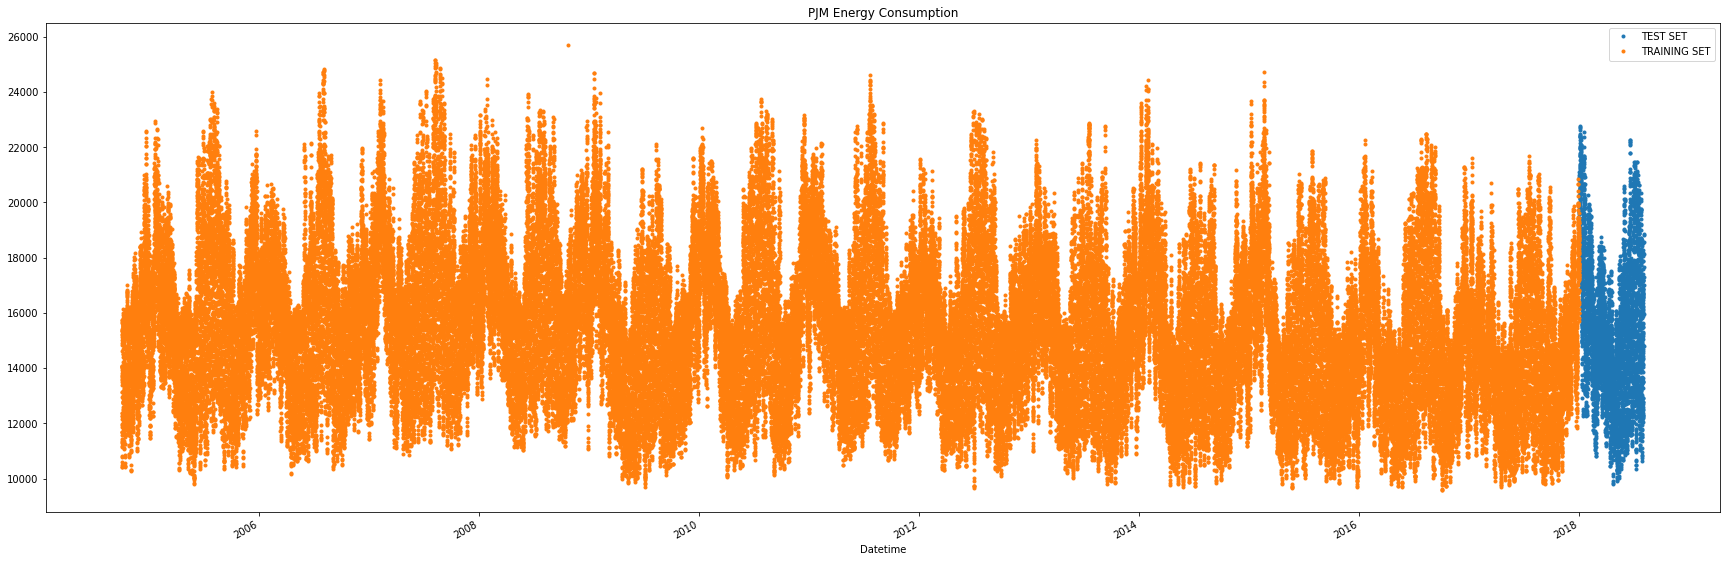

In [77]:
_ = PJM_Test \
    .rename(columns={'AEP_MW': 'TEST SET'}) \
    .join(PJM_Train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(30,10), title='PJM Energy Consumption', style='.')

# Create the features for prediction

In [78]:
def features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year', 'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

# Prediction

In [79]:
X_train, y_train = features(PJM_Train, label='AEP_MW')
X_test, y_test = features(PJM_Test, label='AEP_MW')

<ipython-input-78-2020887f6f9b>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-78-2020887f6f9b>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


# XGBoost

In [88]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

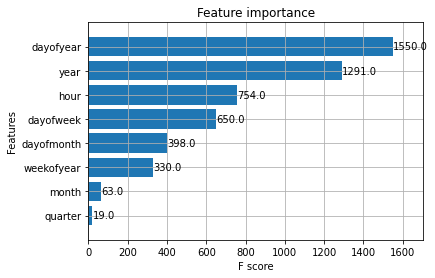

In [81]:
_ = plot_importance(reg, height=0.8)

# Prediction of Train data set

In [82]:
PJM_Test['MW_Prediction'] = reg.predict(X_test)
PJM_All = pd.concat([PJM_Test, PJM_Train], sort=False)

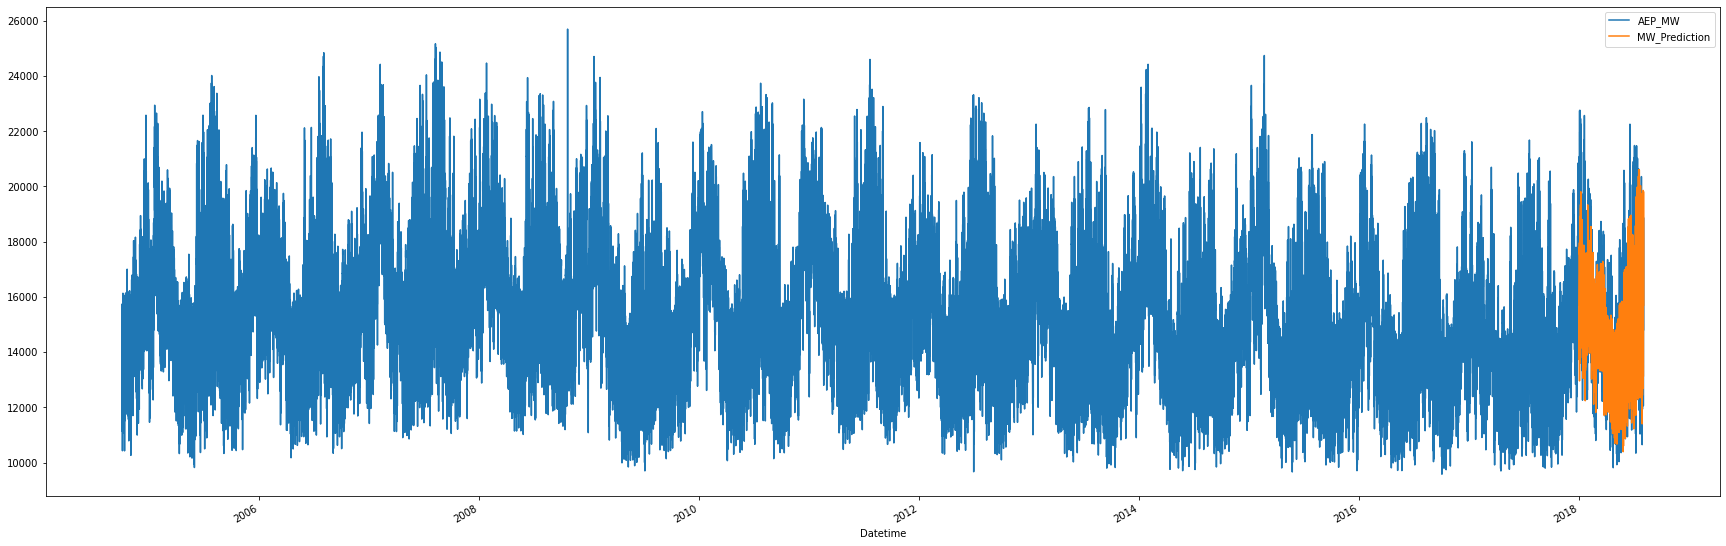

In [83]:
_ = PJM_All[['AEP_MW','MW_Prediction']].plot(figsize=(30, 10))

# Find trends in energy consumption around hours of the day, holidays, or long term trends?

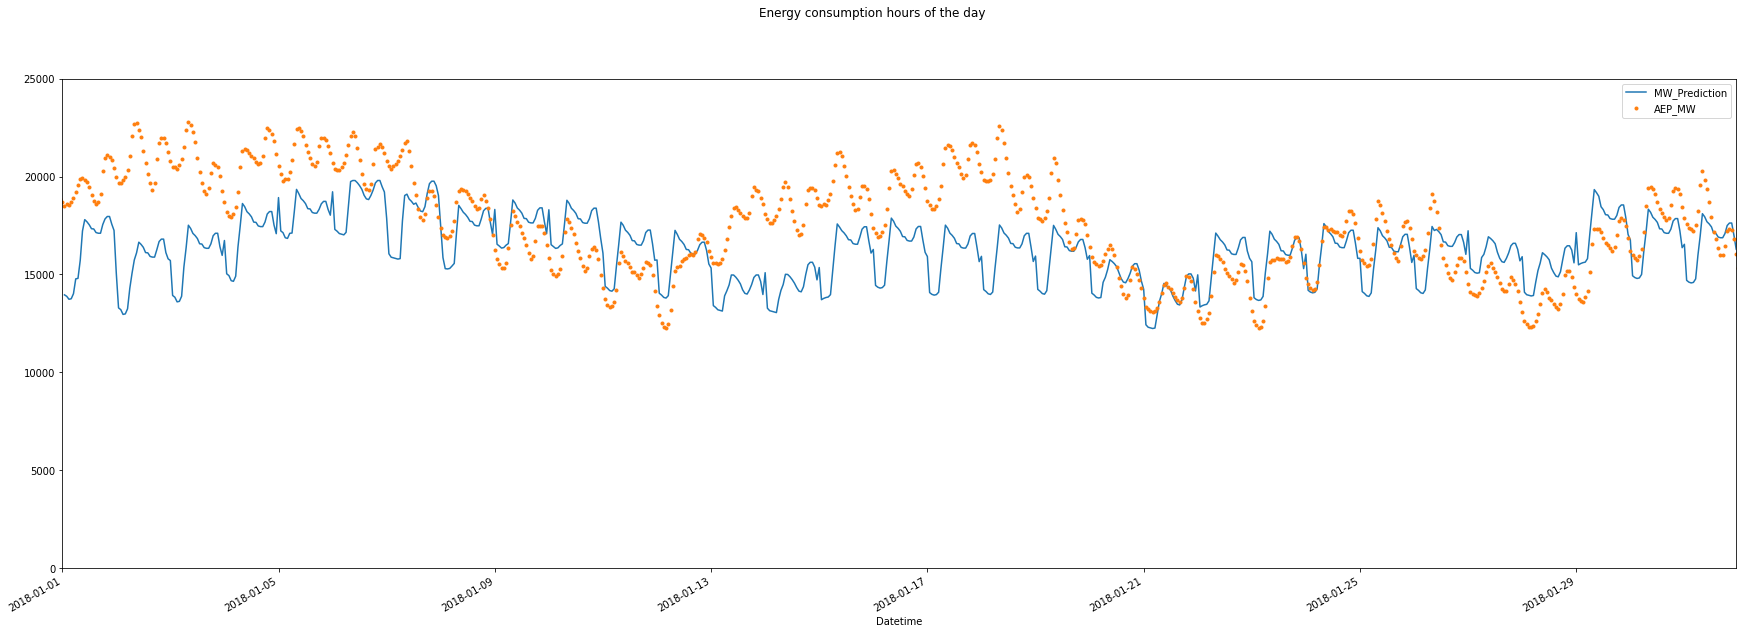

In [91]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(30)
_ = PJM_All[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2018 00:00:00', upper='01-31-2018 23:00:00')
ax.set_ylim(0, 25000)
plot = plt.suptitle('Energy consumption hours of the day')

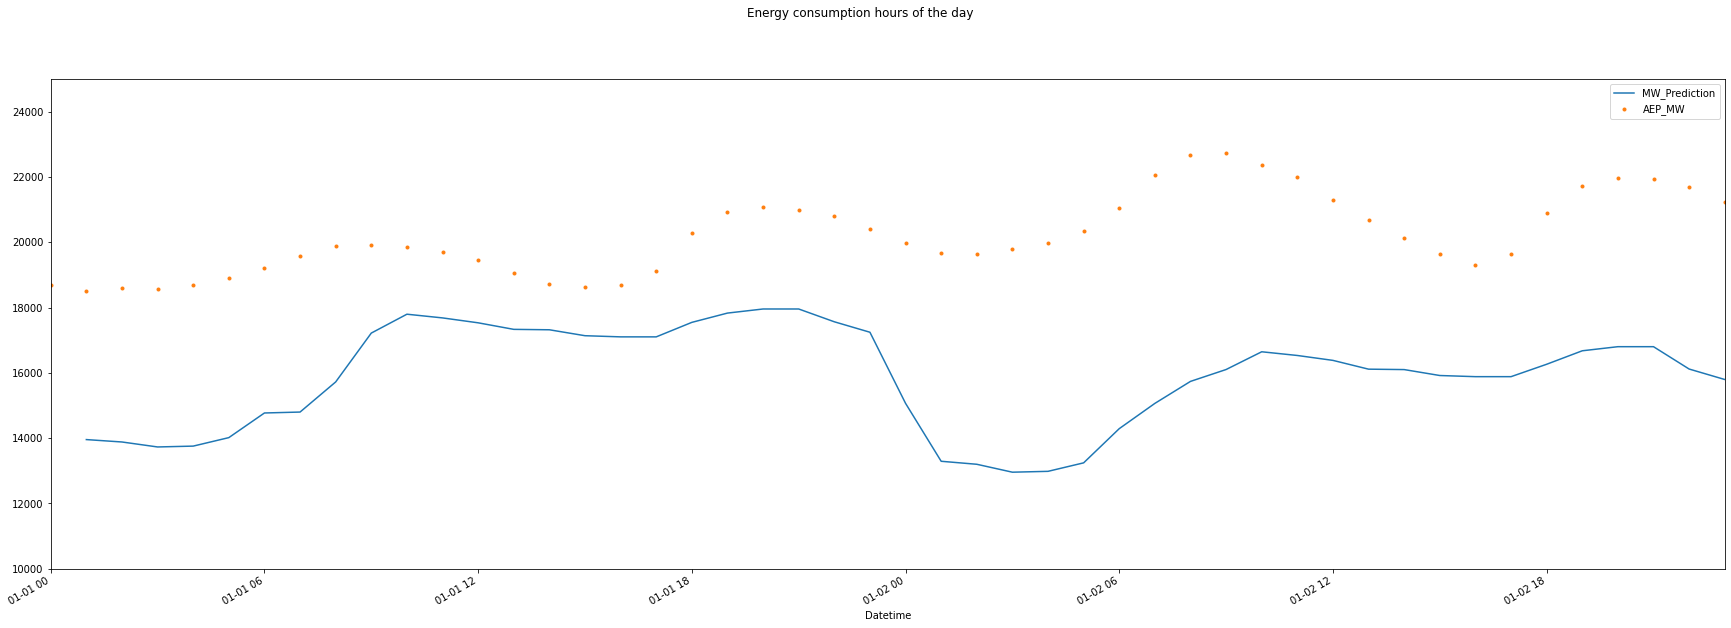

In [92]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(30)
_ = PJM_All[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2018 00:00:00', upper='01-02-2018 23:00:00')
ax.set_ylim(10000, 25000)
plot = plt.suptitle('Energy consumption hours of the day')

# The Energy consumption for hour of the day that indicate increasing usage in the morning until maximum near the noon, then the usage will be deceasing in the night

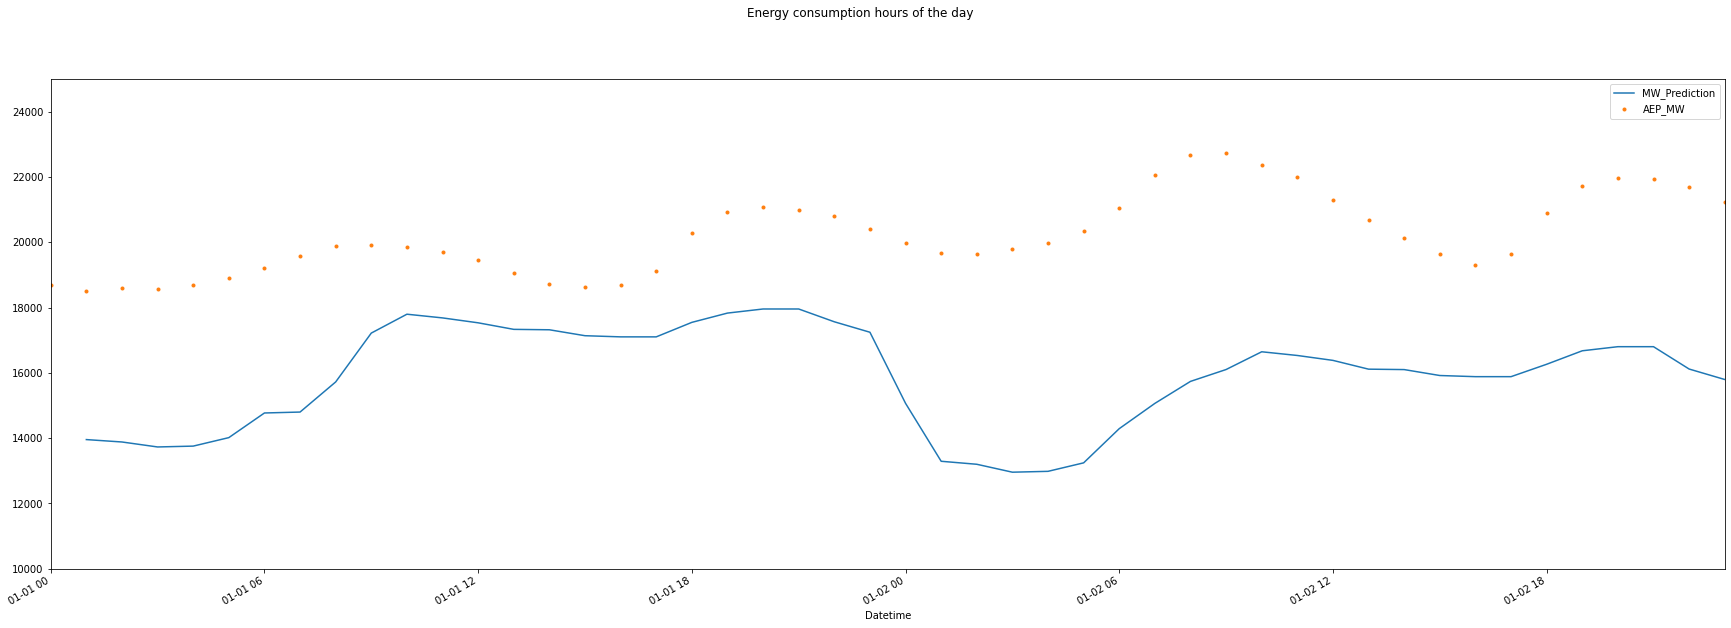

In [93]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(30)
_ = PJM_All[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2018 00:00:00', upper='01-02-2018 23:00:00')
ax.set_ylim(10000, 25000)
plot = plt.suptitle('Energy consumption hours of the day')

# First month 2018 prediction

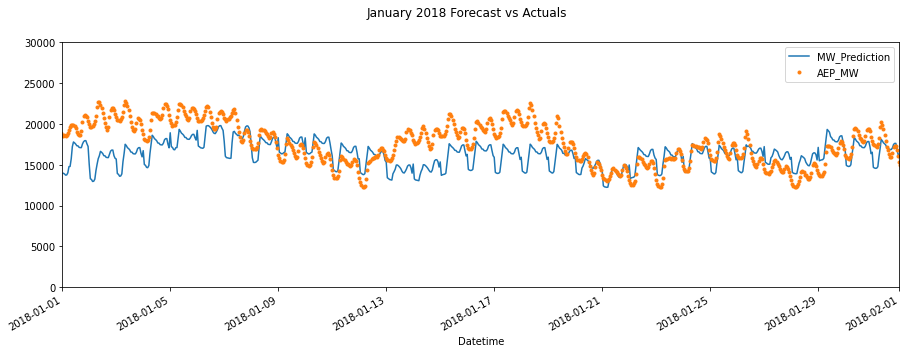

In [86]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = PJM_All[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2018', upper='02-01-2018')
ax.set_ylim(0, 30000)
plot = plt.suptitle('January 2018 Forecast vs Actuals')

# First week of January 2018 prediction

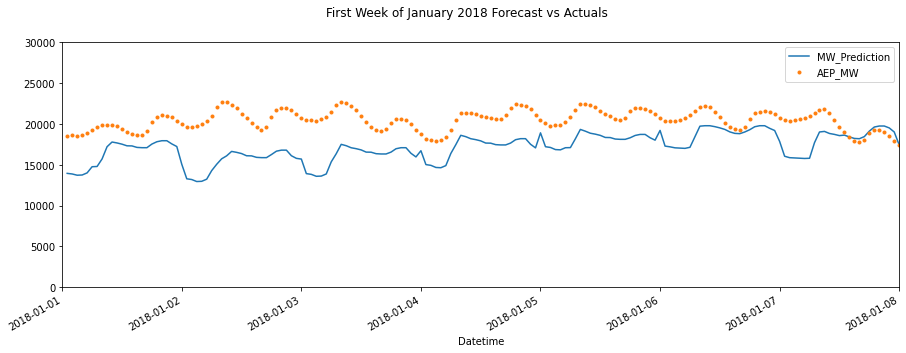

In [101]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = PJM_Test[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound (lower='01-01-2018', upper='01-08-2018')
ax.set_ylim(0, 30000)
plot = plt.suptitle('First Week of January 2018 Forecast vs Actuals')